In [7]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
sign_results = [i for i in os.listdir('binom_reg/') if 'sign' in i]
sites = pd.Series(sign_results).str.split('_').str[-1].str.replace('.csv', '').astype(int).reset_index()

In [3]:
sites[0].values

array([ 2,  5, 24, 11, 32, 49, 10, 25, 57,  4, 46, 48, 45, 42, 13,  9, 53,
       54, 28, 43, 55,  6,  1, 52, 27, 12])

In [17]:
snps_names = pd.read_csv('../key_files/var_pos_grenenet.csv')

import pickle
with open('../key_files/blocks_snpsid_dict.pkl', 'rb') as f:
    dict_blocks = pickle.load(f)

reverse_mapping = {item: key for key, values in dict_blocks.items() for item in values}

#snps_names = snps_names[snps_names['total_alleles05filter_firstgen'].notna()].reset_index(drop=True)

In [23]:
snps_names['total_alleles05filter_firstgen'].notna().sum()

1054574

In [30]:
snps_names['block'] = snps_names['id'].map(reverse_mapping)

In [32]:
snps_names['block'].nunique()

16917

In [36]:
snps_names[snps_names['maf05filter'].notna()]['block'].nunique()

16757

In [38]:
snps_names[snps_names['total_alleles05filter_lastgen'].notna()]['block'].nunique()

16665

In [26]:
dict_snps = pd.read_csv('../key_files/dict_snps.csv')

,id,pos,chrom,maf05filter,total_alleles05filter
0,1_291,291,1,NaN,NaN
1,1_346,346,1,1_346,1_346
2,1_349,349,1,NaN,NaN
3,1_352,352,1,NaN,NaN
4,1_353,353,1,1_353,NaN
...,...,...,...,...,...
3235475,5_26975208,26975208,5,NaN,NaN
3235476,5_26975215,26975215,5,NaN,NaN
3235477,5_26975267,26975267,5,NaN,NaN
3235478,5_26975272,26975272,5,5_26975272,5_26975272


In [25]:
snps_names['maf05filter'].notna().sum()

1147892

In [6]:
binomial_reg = pd.read_csv(f'binom_reg/site_{4}.csv')

In [7]:
binomial_reg

,slope,p_value,id
0,-0.369944,3.110702e-14,1_346
1,-0.584323,1.830801e-12,1_353
2,0.006371,9.254715e-01,1_363
3,0.916588,1.432593e-106,1_395
4,0.916588,1.432593e-106,1_396
...,...,...,...
1147887,-0.091364,3.033673e-02,5_26975078
1147888,-0.230697,1.578186e-03,5_26975121
1147889,-0.230697,1.578186e-03,5_26975148
1147890,0.210222,8.922712e-09,5_26975272


In [14]:
for i in sites[0].values:
    binomial_reg = pd.read_csv(f'binom_reg/site_{i}.csv')
    binomial_reg['block'] = binomial_reg['id'].map(reverse_mapping) 
    binomial_reg['MAF'] = 0.06
    binomial_reg.to_csv(f'binom_reg/site_{i}_wmaf.csv',index=None)

In [13]:
check = pd.read_csv(f'binom_reg/site_4_wmaf.csv')

In [16]:
check

,slope,p_value,id,block,MAF
0,-0.369944,3.110702e-14,1_346,1_0,0.06
1,-0.584323,1.830801e-12,1_353,1_0,0.06
2,0.006371,9.254715e-01,1_363,1_0,0.06
3,0.916588,1.432593e-106,1_395,1_0,0.06
4,0.916588,1.432593e-106,1_396,1_0,0.06
...,...,...,...,...,...
1147887,-0.091364,3.033673e-02,5_26975078,5_3110,0.06
1147888,-0.230697,1.578186e-03,5_26975121,5_3110,0.06
1147889,-0.230697,1.578186e-03,5_26975148,5_3110,0.06
1147890,0.210222,8.922712e-09,5_26975272,5_3110,0.06


In [15]:
check['block'].nunique()

16757

In [22]:
#maf = pd.read_csv('../key_files/maf_all_samples.csv')

In [23]:
#binomial_reg = pd.concat([binomial_reg, maf],axis=1)

In [32]:
#binomial_reg.columns = ['slope', 'pvalue', 'snp_id', 'block', 'MAF']

In [15]:
pwd

'/carnegie/nobackup/scratch/tbellagio/gea_grene-net/snp_origin'

In [130]:
## create a dir 


# create sbatch files to submit on cedar server
shfiles = []
for site in sites[0].values:
    seed = random.randint(1,100000000)
    file = f'wza_{site}.sh'
    cmd = f'python general_WZA_script_mod.py --correlations binom_reg/site_{site}_wmaf.csv --summary_stat p_value --window block --output binom_reg/wza_site_{site}.csv --sep "," --sample_snps 1729 --resample 50'
    text = f'''#!/bin/bash
#SBATCH --job-name=wza_{site}
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_{site}_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/snp_origin
{cmd}


'''
    with open(file, 'w') as o:
        o.write("%s" % text)
    shfiles.append(file)

In [131]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 31719
Submitted batch job 31720
Submitted batch job 31721
Submitted batch job 31722
Submitted batch job 31723
Submitted batch job 31724
Submitted batch job 31725
Submitted batch job 31726
Submitted batch job 31727
Submitted batch job 31728
Submitted batch job 31729
Submitted batch job 31730
Submitted batch job 31731
Submitted batch job 31732
Submitted batch job 31733
Submitted batch job 31734
Submitted batch job 31735
Submitted batch job 31736
Submitted batch job 31737
Submitted batch job 31738
Submitted batch job 31739
Submitted batch job 31740
Submitted batch job 31741
Submitted batch job 31742
Submitted batch job 31743
Submitted batch job 31744


In [5]:
block_origin_bio1 = pd.read_csv('../key_files/block_origin_bio1_1001g.csv')

In [7]:
sign_results = [i for i in os.listdir('binom_reg/') if 'sign' in i]

In [6]:
sites = pd.Series(sign_results).str.split('_').str[-1].str.replace('.csv', '').astype(int).reset_index()

sites.columns = ['ign', 'site']

In [7]:
#clim_sites_during_exp = pd.read_csv('/carnegie/nobackup/scratch/tbellagio/grene/data/bioclimvars_experimental_sites_era5.csv')
clim_sites_during_exp = pd.read_csv('../key_files/bioclimvars_experimental_sites_era5.csv')

clim_sites_during_exp = clim_sites_during_exp[['site', 'bio1']]

clim_sites_during_exp = clim_sites_during_exp.merge(sites['site'])

clim_sites_during_exp_ordered = clim_sites_during_exp.sort_values('bio1')

unique_sites = clim_sites_during_exp_ordered['site'].values

In [10]:
unique_sites

array([24, 27, 48,  1, 42, 46, 25, 55, 49, 52, 57, 53, 54,  9, 12, 11,  6,
        5,  2, 45, 28,  4, 32, 43, 13, 10])

In [11]:
i = 24

In [12]:
wza = pd.read_csv(f'binom_reg/wza_site_{i}.csv')

In [13]:
wza

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal
0,1_0,230,9,-2.708156,0.000587,0.709343
1,1_1,4,0,-1.747527,1.000000,0.831515
2,1_10,22,0,1.924007,1.000000,0.186373
3,1_100,55,0,-1.992862,1.000000,0.778240
4,1_1000,10,0,-0.689811,1.000000,0.643249
...,...,...,...,...,...,...
16752,5_995,48,0,1.793900,1.000000,0.243791
16753,5_996,3,0,-0.922186,1.000000,0.697147
16754,5_997,29,0,-0.201575,1.000000,0.540640
16755,5_998,9,0,0.384973,1.000000,0.424985


In [13]:
## addd where the block comes from and also add the mean of the slope for that block 
for i in unique_sites:
    print(i)
    wza = pd.read_csv(f'binom_reg/wza_site_{i}.csv')
    result_site = pd.read_csv(f'binom_reg/site_{i}.csv')
    result_site['block'] = result_site['id'].map(reverse_mapping)
    slopes = result_site.groupby('block')['slope'].median().reset_index()
    wza = wza.merge(slopes, left_on='gene', right_on = 'block').merge(block_origin_bio1, left_on='gene', right_on = 'blocks')
    wza.to_csv(f'binom_reg/wza_site_{i}_pr.csv',index=None)

24
27
48
1
42
46
25
55
49
52
57
53
54
9
12
11
6
5
2
45
28
4
32
43
13
10


In [121]:
site = pd.read_csv(f'binom_reg/wza_site_{site_value}_pr.csv')

In [19]:
len(unique_sites)

26

In [132]:
pd.read_csv(f'binom_reg/wza_site_{4}_pr.csv')

,gene,SNPs,hits,Z,top_candidate_p,Z_pVal,block,slope,blocks,snp_origin_bio1
0,1_0,230,0,-1.071356,1.0,0.567224,1_0,0.051220,1_0,-0.026863
1,1_1,4,0,-2.384460,1.0,0.887435,1_1,0.072292,1_1,0.001980
2,1_10,22,0,1.748989,1.0,0.189224,1_10,0.415244,1_10,0.073968
3,1_100,55,0,1.100985,1.0,0.319687,1_100,-0.329703,1_100,-0.033849
4,1_1000,10,0,1.100894,1.0,0.262202,1_1000,-0.515554,1_1000,-0.228123
...,...,...,...,...,...,...,...,...,...,...
16752,5_995,48,0,-0.528624,1.0,0.557259,5_995,-0.308736,5_995,0.043812
16753,5_996,3,0,-0.893466,1.0,0.659656,5_996,0.180606,5_996,0.025821
16754,5_997,29,0,-2.997831,1.0,0.895331,5_997,0.156857,5_997,0.016168
16755,5_998,9,0,-0.125998,1.0,0.496822,5_998,-0.233770,5_998,-0.008437


In [ ]:
import math

def log_odds_to_probability(log_odds):
    return 1 / (1 + np.exp(-log_odds))


In [57]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 

24
27
48
1
42
46
25
55
49
52
57
53
54
9
12
11
6
5
2
45
28
4
32
43


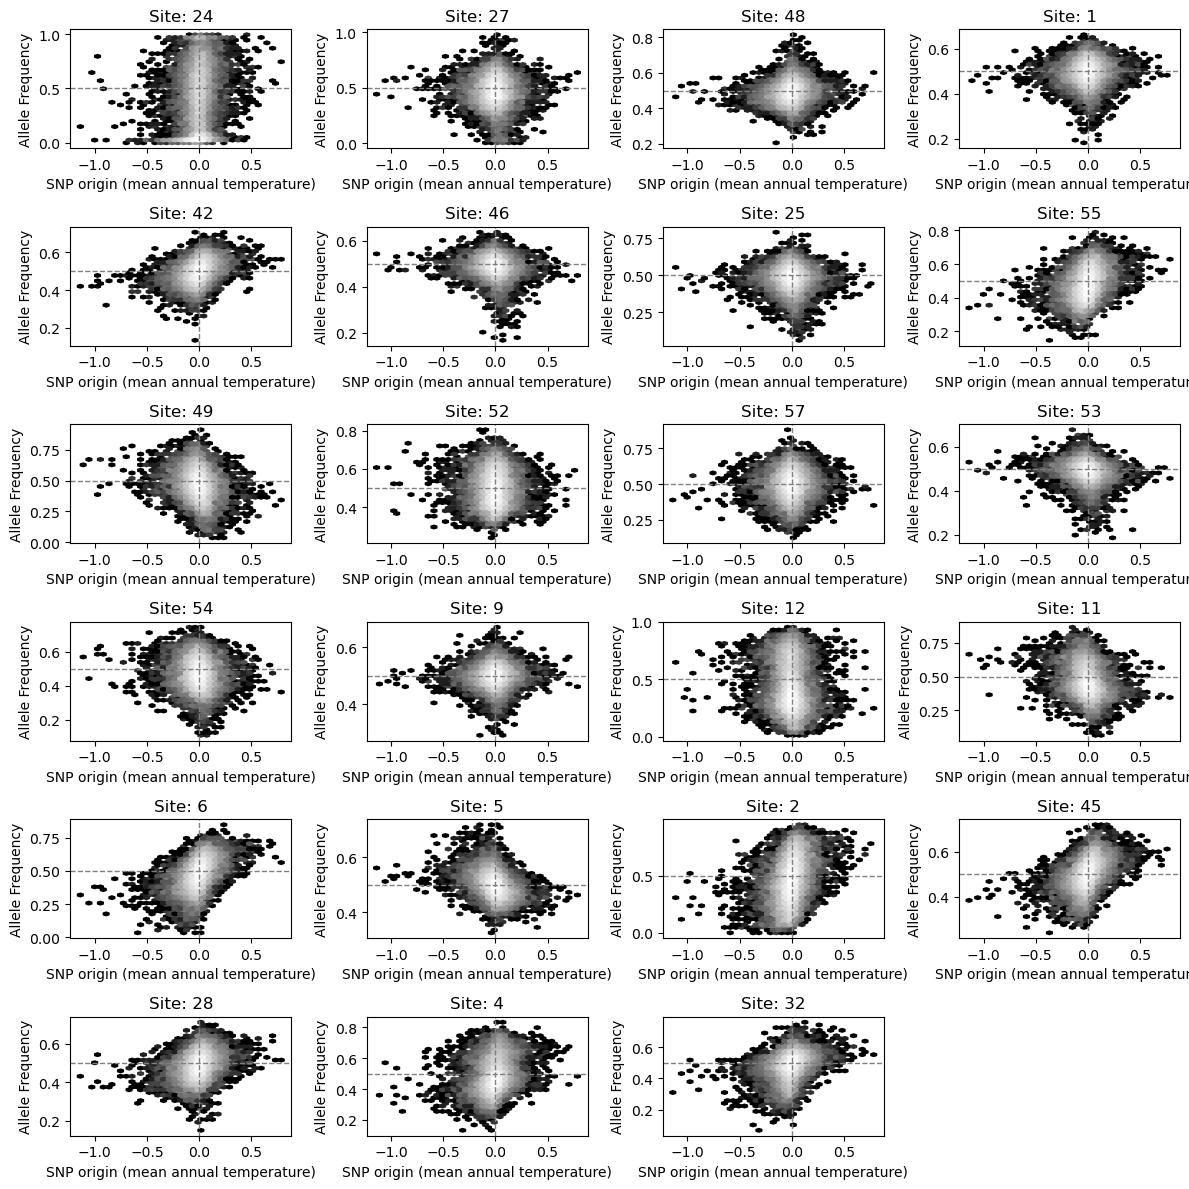

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming results_sign is a list of filenames and snp_origin_bio1 is a DataFrame
n_plots = 6  # Number of subplots

# Create a grid of subplots with shared x and y axes
fig, axes = plt.subplots(nrows=n_plots, ncols=4, figsize=(12, 2 * n_plots))

# Flatten the axes array to iterate over it as a 1D list
axes = axes.flatten()

# To ensure consistent color scaling across all plots, you can optionally define a norm
norm = plt.Normalize(site['slope'].min(), site['slope'].max())

# Loop through results_sign and plot each site
for i, (ax, site_value) in enumerate(zip(axes, unique_sites)):
    site = pd.read_csv(f'binom_reg/wza_site_{site_value}_pr.csv')
    print(site_value)

    # Convert log odds to probabilities
    site['slope'] = log_odds_to_probability(site['slope'])

    # Create a hexbin plot for each result on its corresponding subplot
    hb = ax.hexbin(
        site['snp_origin_bio1'],
        site['slope'],
        gridsize=35,  # Specifies the number of hexagons in the x-direction, adjust as needed
        cmap='Greys_r',  # Color map for density
        #mincnt=1,  # Minimum count of points to color a hexagon
        #norm=norm,  # Use the defined normalization for consistent coloring
        #reduce_C_function=np.mean  # Function to reduce C within each bin
        bins='log',  # Use logarithmic counts for coloring
        mincnt=1  # Minimum count number to display a hexagon
    )

    # Set title for each subplot
    ax.set_title(f"Site: {site_value}")
    
    # Add dotted grey horizontal and vertical lines at y=0.5 and x=0
    ax.axhline(0.5, color='grey', linestyle='--', linewidth=1)
    ax.axvline(0, color='grey', linestyle='--', linewidth=1)
    
    # Set axis labels for each subplot
    ax.set_xlabel("SNP origin (mean annual temperature)")
    ax.set_ylabel("Allele Frequency")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
# Configure the last subplot for the colorbar
cbar_ax = axes[-1]  # Use the last subplot for the colorbar
fig.colorbar(hb, cax=cbar_ax, orientation='vertical', label='Density')
cbar_ax.set_visible(False)  # Hide the axes of the last subplot, only show the colorbar




# Adjust layout and show the figure
plt.tight_layout()
plt.savefig('block_origin_across_time_hexbin.pdf')
plt.show()
